<html><head><meta content="text/html; charset=UTF-8" http-equiv="content-type"><style type="text/css">ol</style></head><body class="c5"><p class="c0 c4"><span class="c3"></span></p><p class="c2 title" id="h.rrbabt268i6e"><h1>CaImAn&rsquo;s Demo pipeline</h1></p><p class="c0"><span class="c3">This notebook will help to demonstrate the process of CaImAn and how it uses different functions to denoise, deconvolve and demix neurons from a Calcium Imaging Video. </span></p>
<p><img src="../../docs/img/quickintro.png" /></p>
<p class="c0"><span class="c3">More information can be found in CaImAn&rsquo;s documentation. </span></p>
</html>



In [25]:
#!/usr/bin/env python
from __future__ import division
from __future__ import print_function

try:
    get_ipython().magic(u'load_ext autoreload')
    get_ipython().magic(u'autoreload 2')    
except:
    print('Not IPYTHON')

get_ipython().magic(u'matplotlib qt')
import numpy as np
import matplotlib.pyplot as plt
import caiman as cm
from caiman.source_extraction import cnmf
from caiman.utils.utils import download_demo
from caiman.utils.visualization import inspect_correlation_pnr
from caiman.components_evaluation import estimate_components_quality_auto
from caiman.motion_correction import motion_correct_oneP_rigid, motion_correct_oneP_nonrigid
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
import cv2

try:
    cv2.setNumThreads(0)
except:
    pass
import bokeh.plotting as bpl
bpl.output_notebook()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

### Setup some parameters
few of them (that typically shouldn't be changed for 1p data) will be set directly calling the CNMF object

In [26]:
# dataset dependent parameters
# fnames = ['data_endoscope.tif']  # filename to be processed
frate = 10                       # movie frame rate
decay_time = 0.1                 # length of a typical transient in seconds

In [27]:
# motion correction parameters
do_motion_correction_nonrigid = False
do_motion_correction_rigid = not  do_motion_correction_nonrigid # in this case it will also save a rigid motion corrected movie
gSig_filt = (4, 4)       # size of filter, in general gSig (see below),
#                          change this one if algorithm does not work
max_shifts = (5, 5)      # maximum allowed rigid shift
splits_rig = 10          # for parallelization split the movies in  num_splits chuncks across time
strides = (48, 48)       # start a new patch for pw-rigid motion correction every x pixels
overlaps = (24, 24)      # overlap between pathes (size of patch strides+overlaps)
splits_els = 10          # for parallelization split the movies in  num_splits chuncks across time
#                          (remember that it should hold that length_movie/num_splits_to_process_rig>100)
upsample_factor_grid = 4 # upsample factor to avoid smearing when merging patches
max_deviation_rigid = 3  # maximum deviation allowed for patch with respect to rigid shifts

Download the dataset if not already present

In [4]:
# fnames = ['/home/sebastian/Desktop/32364_trial_20170710_120637-cropped.tif']#[download_demo(fnames[0])]

In [5]:
fnames = ['/home/sebastian/Desktop/32364_20170710_120637_trial.tif']

In [6]:
#plt.imshow(mv[:,0,:])

### (Re)start cluster.  

In [7]:
import psutil

# stop the cluster if one exists
n_processes = psutil.cpu_count()
print('using ' + str(n_processes) + ' processes')
print("Stopping  cluster to avoid unnencessary use of memory....")

using 16 processes
Stopping  cluster to avoid unnencessary use of memory....


In [8]:
try:
    cm.stop_server(dview=dview) # stop it if it was running
except:
    pass

c, dview, n_processes = cm.cluster.setup_cluster(backend='local', # use this one
                                                 n_processes=n_processes,  # number of process to use, if you go out of memory try to reduce this one
                                                 )

0
10
20
30
40
50
60
70
0
80
10
90
20
0
0
0
0
0
0
0
0
100
30
10
10
10
10
10
10
10
10
110
40
20
20
20
20
20
20
20
20
120
50
30
30
30
30
30
30
30
30
40
60
130
40
40
40
40
40
40
50
40
140
70
150
50
50
50
160
50
50
170
60
50
180
80
50
60
60
60
60
60
190
70
60
60
70
70
90
70
70
70
200
70
80
80
80
70
80
80
100
80
210
80
90
90
90
220
90
80
110
90
90
90
100
230
100
100
100
100
90
120
110
100
240
110
110
100
110
120
130
110
110
100
250
120
120
120
130
110
120
130
140
130
110
120
130
260
140
140
140
130
120
150
120
150
140
150
130
270
150
140
130
160
130
150
160
160
140
150
170
160
140


/home/sebastian/Documents/CaImAn/caiman/motion_correction.py:2457: RuntimeWarning: Mean of empty slice
  new_temp = np.nanmean(mc, 0)


170
170
140
180
160
150
160
190
180
150
170
150
190
180
200
170
160
170
200
160
180
210
190
160
210
220
190
220
180
230
170
230
200
180
200
240
190
170
240
170
180
190
210
180
200
210
180
190
250
250
200
190
200
210
210
220
220
190
200
220
210
260
220
260
230
230
200
270
230
270
210
220
240
240
230
240
210
250
220
250


/home/sebastian/Documents/CaImAn/caiman/motion_correction.py:2457: RuntimeWarning: Mean of empty slice
  new_temp = np.nanmean(mc, 0)


230
240
240
250
230
220
260
260
250
240
250
260
230
260
270
250
270
270
240
260
260
270
250


/home/sebastian/Documents/CaImAn/caiman/motion_correction.py:2457: RuntimeWarning: Mean of empty slice
  new_temp = np.nanmean(mc, 0)


270
270
260


/home/sebastian/Documents/CaImAn/caiman/motion_correction.py:2457: RuntimeWarning: Mean of empty slice
  new_temp = np.nanmean(mc, 0)
/home/sebastian/Documents/CaImAn/caiman/motion_correction.py:2457: RuntimeWarning: Mean of empty slice
  new_temp = np.nanmean(mc, 0)


270


/home/sebastian/Documents/CaImAn/caiman/motion_correction.py:2457: RuntimeWarning: Mean of empty slice
  new_temp = np.nanmean(mc, 0)


0
0
0
0
0
0
0


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in true_divide
  return a / b
/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in true_divide
  return a / b
/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in true_divide
  return a / b
/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in true_divide
  return a / b
/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in true_divide
  return a / b


10
10
10
10
10
10
10
20
20
20
30
20
20
20
20
30
40
30
40
30
30
30
30
50
40
50
40
40
60
40
60
40
50
50
50
70
70
50
50
60
60
60
80
80
90
70
60
70
90
60
70
100
100
80
80
70
80
70
110
110
90
120
120
90
90
80
80
100
130
130
100
110
140
90
100
90
140
110
150
120
110
150
100
100
160
120
160
130
120
110
170
110
170
130
130
140
180
120
180
120
140
190
140
150
190
200
130
150
150
130
200
160
210
140
160
210
220
160
140
170
150
220
170
230
170
180
150
230
240
180
160
180
190
250
240
160
190
170
190
200
250
260
170
200
180
260
270
210
200
210
180
190


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in true_divide
  return a / b


270
220
210
220
190


/home/sebastian/Documents/CaImAn/caiman/motion_correction.py:2457: RuntimeWarning: Mean of empty slice
  new_temp = np.nanmean(mc, 0)


200
230
230
220
200
210
240
240
230
210
220
250
250
240
220
230
260
260
250
230
240
270
270
260
240
250
270
260
250
270
260
270


/home/sebastian/Documents/CaImAn/caiman/motion_correction.py:2457: RuntimeWarning: Mean of empty slice
  new_temp = np.nanmean(mc, 0)


0
0
0
0
0
0
0
0
0
0


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in true_divide
  return a / b
/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in true_divide
  return a / b
/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in true_divide
  return a / b
/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in true_divide
  return a / b
/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in true_divide
  return a / b
/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in true_divide
  return a / b


10
10
10
10
10
10
10
10
10
10
20
20
20
20
20
20
20
20
30
20
20
30
30
30
40
30
30
40
30
40
30
30
30
50
40
50
40
40
60
50
40
40
40
50
40
60
50
50
70
60
50
70
50
60
50
50
80
60
60
70
80
70
60
90
60
60
60
70
70
90
80
80
100
70
70
70
80
100
80
70
90
90
110
110
80
80
90
90
80
100
120
100
80


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in true_divide
  return a / b


120
130
90
100
90
110
100
110
90
130
90
140
120
110
100
120
110
100
140
100
150
130
100
120
130
110
120
150
110
160
140
110
160
140
110
130
120
130
170
120
170
150
120
150
140
120
180
140
130
180
130
160
160
130
190
150
130
190
150
140
170
200
140
170
160
200
140
140
160
180
210
150
210
170
180
150
150
220
190
170
150
220
160
180
190
230
160
200
180
160
230
160
190
240
200
170
210
240
170
190
170
250
170
200
210
220
250
180
180
200
260
180
180
230
210
220
260
190
270
190
210
190
240
220
270
190
230


/home/sebastian/Documents/CaImAn/caiman/motion_correction.py:2457: RuntimeWarning: Mean of empty slice
  new_temp = np.nanmean(mc, 0)


200
200
250
220
200
230
240
200
210
230
260
240
210
250
210
240
270
210
250
220
260
220
250


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in true_divide
  return a / b


260
220
270
220


/home/sebastian/Documents/CaImAn/caiman/motion_correction.py:2457: RuntimeWarning: Mean of empty slice
  new_temp = np.nanmean(mc, 0)


230
260
230
270
230
270
230
240
240
240


/home/sebastian/Documents/CaImAn/caiman/motion_correction.py:2457: RuntimeWarning: Mean of empty slice
  new_temp = np.nanmean(mc, 0)


240
250
250
250
250
260
260
260
260
270
270
270
270
(2800, 97, 96)
using 1 processes
using 2304 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
(2800, 97, 97)
using 1 processes
(2800, 97, 97)
using 2304 pixels per process
using 5000 block_size
preprocessing ...
using 1 processes
using 2304 pixels per process
using 5000 block_size
(2800, 97, 97)
checking if missing data
using 1 processes
using 2304 pixels per process
preprocessing ...
checking if missing data
using 5000 block_size
(2800, 97, 97)
preprocessing ...
(2800, 97, 97)
using 1 processes
checking if missing data
using 2304 pixels per process
using 1 processes
using 5000 block_size
preprocessing ...
using 2304 pixels per process
checking if missing data
using 5000 block_size
(2800, 97, 97)
preprocessing ...
using 1 processes
checking if missing data
using 2304 pixels per process
using 5000 block_size
preprocessing ...
(2800, 97, 97)
checking if missing data
using 1 processes
using 2304 pixels p

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Update Spatial
Update Spatial
Update Spatial
Initializing update of Spatial Components
Initializing update of Spatial Components
Initializing update of Spatial Components
computing the distance indicators
computing the distance indicators
computing the distance indicators


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)
/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)
/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


memmaping
Updating Spatial Components using lasso lars
memmaping
Updating Spatial Components using lasso lars
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 8.298610210418701 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
2 out of total 2 temporal components updated
2 out of total 2 temporal components updated
stopping: overall temporal component not changing significantly
Initialization again
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
Update Spatial
Initializing update of Spatial Components
--- 10.995737075805664 seconds ---
computing the distance indicators
Removing tempfiles created
Update Temporal
Generating residuals
thresholding components
Computing residuals
--- 11.179822206497192 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
thresholding components
Computing residuals
--- 11.6054410

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


entering the deconvolution 
stopping: overall temporal component not changing significantly
Initialization again
Update Spatial
Initializing update of Spatial Components
computing the distance indicators


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In total,  4 neurons were initialized.
Merge Components
Update Spatial
Initializing update of Spatial Components
computing the distance indicators


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


[1 2 3 4 5]
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
0 neurons have been initialized
0 neurons have been initialized
Update Spatial
Initializing update of Spatial Components
In total,  1 neurons were initialized.
computing the distance indicators
Merge Components


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


[0 1 2 3]
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
Update Spatial
Initializing update of Spatial Components
computing the distance indicators


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Update Spatial
Initializing update of Spatial Components
computing the distance indicators


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


0 neurons have been initialized
memmaping
In total,  3 neurons were initialized.
Updating Spatial Components using lasso lars
Merge Components
In total,  7 neurons were initialized.
Merge Components
[0 4 6]
[1 5]
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
[ 0  7  9 10]
[ 6 11]
memmaping
Updating Spatial Components using lasso lars
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
In total,  0 neurons were initialized.
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 5.909661054611206 seconds ---
Removing tempfiles created
U

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
entering the deconvolution 
stopping: overall temporal component not changing significantly
Initialization again
4 out of total 4 temporal components updated
entering the deconvolution 
memmaping
4 out of total 4 temporal components updated
stopping: overall temporal component not changing significantly
Initialization again
Updating Spatial Components using lasso lars
8 out of total 8 temporal components updated
entering the deconvolution 
3 out of total 4 temporal components updated
4 out of total 4 temporal components updated
memmaping
8 out of total 8 temporal components updated
Updating Spatial Components using lasso lars
3 out of total 4 temporal components updated
stopping: overall temporal component not changing significantly
4 out of total 4 temporal components updated
Compute Background Again
stopping: overall temporal component not changing significantly
Initialization again
thresholdi

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


Removing tempfiles created
entering the deconvolution 
Generating residuals
stopping: overall temporal component not changing significantly
Update Temporal
Generating residuals
Initialization again
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


thresholding components
--- 6.235853910446167 seconds ---
entering the deconvolution 
Removing tempfiles created
stopping: overall temporal component not changing significantly
Computing residuals
--- 3.052323818206787 seconds ---
Update Temporal
Initialization again


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


Removing tempfiles created
Generating residuals
entering the deconvolution 
Update Temporal
stopping: overall temporal component not changing significantly
Initialization again
Generating residuals
thresholding components
Computing residuals
entering the deconvolution 
--- 2.904057502746582 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
4 out of total 4 temporal components updated


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


In total,  0 neurons were initialized.
entering the deconvolution 
stopping: overall temporal component not changing significantly
Merge Components
Initialization again
4 out of total 4 temporal components updated
stopping: overall temporal component not changing significantly
Compute Background Again
[0 1]
Update Spatial
Initializing update of Spatial Components


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


computing the distance indicators
entering the deconvolution 
stopping: overall temporal component not changing significantly
Initialization again
0 neurons have been initialized
In total,  2 neurons were initialized.
Merge Components
[1 3 4]
[0 2]
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
In total,  0 neurons were initialized.
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
0 neurons have been initialized
In total,  2 neurons were initialized.
In total,  0 neurons were initialized.
Merge Components
[0 1]
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
In total,  0 neurons were initialized.
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
Update Spatia

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


memmaping
Updating Spatial Components using lasso lars
In total,  0 neurons were initialized.
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
In total,  0 neurons were initialized.
Merge Components
In total,  3 neurons were initialized.
No neurons merged!
Update Spatial
Initializing update of Spatial Components
Merge Components
computing the distance indicators
[0 3 5]
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
thresholding components
Computing residuals
--- 3.3069090843200684 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
memmaping
Updating Spatial Components using lasso lars
thresholding components
memmaping
Computing residuals
Updating Spatial Components using lasso lars
--- 6.7405664920806885 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
stopping: overall temporal compone

checking if missing data
Compute Background
Compute Background
initializing ...
Spatial Downsampling 1-photon
0 neurons have been initialized
Roi Extraction...
One photon initialization..
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
0 neurons have been initialized
In total,  2 neurons were initialized.
Merge Components
No neurons merged!
Merge Components
Update Spatial
No neurons merged!
Initializing update of Spatial Components
Update Spatial
computing the distance indicators
Initializing update of Spatial Components
computing the distance indicators
In total,  8 neurons were initialized.
Compute Background
Compute Background
memmaping
Updating Spatial Components using lasso lars
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
Merge Components
0 neurons have been initialized
No neurons merged!
Update Spatial
Initializing updat

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


thresholding components
Computing residuals
--- 9.644132137298584 seconds ---
Removing tempfiles created
Update Temporal
Update Spatial
Generating residuals
Initializing update of Spatial Components
computing the distance indicators
Spatial Downsampling 1-photon
thresholding components
Computing residuals
--- 4.806463956832886 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
(2800, 97, 97)
using 1 processes
using 2304 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


memmaping
entering the deconvolution 
stopping: overall temporal component not changing significantly
Updating Spatial Components using lasso lars
Initialization again
initializing ...
(2800, 97, 97)
using 1 processes
using 2304 pixels per process
using 5000 block_size
Spatial Downsampling 1-photon
preprocessing ...
entering the deconvolution 
checking if missing data
Roi Extraction...
One photon initialization..
4 out of total 4 temporal components updated
4 out of total 4 temporal components updated
stopping: overall temporal component not changing significantly
Return full Background
thresholding components
Computing residuals
(2800, 97, 97)
--- 3.72094464302063 seconds ---
using 1 processes
Removing tempfiles created
using 2304 pixels per process
using 5000 block_size
preprocessing ...
Update Temporal
Generating residuals
checking if missing data
initializing ...
0 neurons have been initialized
Roi Extraction...


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


entering the deconvolution 
One photon initialization..
stopping: overall temporal component not changing significantly
Initialization again
Spatial Downsampling 1-photon
initializing ...
Spatial Downsampling 1-photon
True
memmaping
Updating Spatial Components using lasso lars
initializing ...
Roi Extraction...
One photon initialization..
memmaping
Updating Spatial Components using lasso lars
Spatial Downsampling 1-photon
Roi Extraction...
One photon initialization..
0 neurons have been initialized
In total,  1 neurons were initialized.
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
initializing ...
Spatial Downsampling 1-photon
Roi Extraction...
One photon initialization..
0 neurons have been initialized
initializing ...
In total,  0 neurons were initialized.
thresholding components
Computing residuals
--- 5.695274591445923 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
Spatial

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


stopping: overall temporal component not changing significantly
Updating Spatial Components using lasso lars
Return full Background
In total,  14 neurons were initialized.
Compute Background
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
Compute Background
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
True
0 neurons have been initialized
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 6.494761228561401 seconds ---
(2800, 97, 97)
Removing tempfiles created
using 1 processes
Update Temporal
Generating residuals
using 2304 pixels per process
memmaping
using 5000 block_size
Updating Spatial Components using lasso lars
preprocessing ...
checking if missing data
entering the deconvolution 


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


entering the deconvolution 
memmaping
stopping: overall temporal component not changing significantly
Updating Spatial Components using lasso lars
Return full Background
initializing ...
True
Spatial Downsampling 1-photon
Update Spatial
Initializing update of Spatial Components
computing the distance indicators


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Roi Extraction...
One photon initialization..
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 5.870490074157715 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
2 out of total 3 temporal components updated
3 out of total 3 temporal components updated
2 out of total 3 temporal components updated
3 out of total 3 temporal components updated
stopping: overall temporal component not changing significantly
Return full Background
memmaping
Updating Spatial Components using lasso lars
(2800, 97, 97)
using 1 processes
using 2304 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
thresholding components
Computing residuals
--- 8.830472946166992 seconds ---
Removing tempfiles created
In total,  10 neurons were initialized.
Update Temporal
Generating residuals
memmaping
Updating Spatial Components using lasso lars
entering the deconvolution 
1 out of total

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


initializing ...
Spatial Downsampling 1-photon
memmaping
Updating Spatial Components using lasso lars
Roi Extraction...
One photon initialization..
In total,  0 neurons were initialized.
(2800, 97, 97)
using 1 processes
using 2304 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
Compute Background
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 10.256798267364502 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
initializing ...
Spatial Downsampling 1-photon
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
entering the deconvolution 
5 out of total 7 temporal components updated
7 out of total 7 temporal components updated
memmaping
5 out of total 7 temporal components updated
Updating Spatial Components using lasso lars
Roi Extraction...
One photon initialization..
7 out of total 7 temporal components updated
thresholding componen

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


entering the deconvolution 
stopping: overall temporal component not changing significantly
Initialization again
entering the deconvolution 
4 out of total 5 temporal components updated
5 out of total 5 temporal components updated
thresholding components
4 out of total 5 temporal components updated
5 out of total 5 temporal components updated
stopping: overall temporal component not changing significantly
Initialization again
Computing residuals
--- 15.927852630615234 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
7 out of total 18 temporal components updated
11 out of total 18 temporal components updated
14 out of total 18 temporal components updated
15 out of total 18 temporal components updated
16 out of total 18 temporal components updated
17 out of total 18 temporal components updated
18 out of total 18 temporal components updated
memmaping
Updating Spatial Components using lasso lars
7 out of total 18 temporal components up

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


(2800, 97, 97)
using 1 processes
using 2304 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
memmaping
Updating Spatial Components using lasso lars
In total,  0 neurons were initialized.
thresholding components
eliminating 1 empty spatial components
Computing residuals
--- 22.22089171409607 seconds ---
Removing tempfiles created
Update Temporal
memmaping
Generating residuals
Updating Spatial Components using lasso lars
0 neurons have been initialized
Compute Background
thresholding components
Computing residuals
--- 12.281183958053589 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
memmaping
8 out of total 21 temporal components updated
Updating Spatial Components using lasso lars
11 out of total 21 temporal components updated
Update Spatial
14 out of total 21 temporal components updated
Initializing update of Spatial Components
computing the distance indicators
initializing ...
18 out of total 2

Removing tempfiles created
Update Temporal
Generating residuals
0 neurons have been initialized
entering the deconvolution 
stopping: overall temporal component not changing significantly
Compute Background Again
initializing ...
Spatial Downsampling 1-photon
0 neurons have been initialized
Roi Extraction...
One photon initialization..
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 5.508606910705566 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
stopping: overall temporal component not changing significantly
Initialization again
In total,  9 neurons were initialized.
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
Merge Components
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
[ 2  4  7  8  9 10 12 13 16 17 22]
[ 6 14 18 20 21]
[ 0 15]
Update Spatial
Initializing update of Spatial Componen

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


entering the deconvolution 
stopping: overall temporal component not changing significantly
Initialization again
[ 0  1  3  6  7  8  9 10 11 12]
[ 4 13]
thresholding components
Computing residuals
Update Spatial
--- 5.8865578174591064 seconds ---
Initializing update of Spatial Components
Removing tempfiles created
Update Temporal
computing the distance indicators
Generating residuals
In total,  5 neurons were initialized.
entering the deconvolution 
3 out of total 4 temporal components updated
4 out of total 4 temporal components updated
3 out of total 4 temporal components updated
4 out of total 4 temporal components updated
stopping: overall temporal component not changing significantly
Initialization again
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 15.65204119682312 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
Compute Background
entering the deconvolution 
6 out of total 7 temporal components 

Removing tempfiles created
Update Temporal
thresholding components
Generating residuals
Computing residuals
--- 17.105459690093994 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
Merge Components
Merge Components
[1 2 4]
entering the deconvolution 
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
6 out of total 8 temporal components updated
8 out of total 8 temporal components updated
6 out of total 8 temporal components updated
entering the deconvolution 
8 out of total 8 temporal components updated
stopping: overall temporal component not changing significantly
Compute Background Again
4 out of total 4 temporal components updated
initializing ...
4 out of total 4 temporal components updated
stopping: overall temporal component not changing significantly
Return full Background
Spatial Downsampling 1-photon
M

Computing residuals
--- 14.21700668334961 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
initializing ...
Spatial Downsampling 1-photon
initializing ...
Spatial Downsampling 1-photon
Roi Extraction...
One photon initialization..
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
entering the deconvolution 
computing the distance indicators
thresholding components
Computing residuals
--- 9.30838656425476 seconds ---
Removing tempfiles created
(2800, 96, 96)
Update Temporal
using 1 processes
Generating residuals
using 2304 pixels per process
5 out of total 7 temporal components updated
using 5000 block_size
preprocessing ...
6 out of total 7 temporal components updated
checking if missing data
7 out of total 7 temporal components updated
5 out of total 7 temporal components updated
Roi Extraction...
One photon initialization..
6 out of total 7 temporal components updated
7 out of total 7 temporal components updated
st

Generating residuals
Update Temporal
computing the distance indicators
Generating residuals
entering the deconvolution 
3 out of total 3 temporal components updated
3 out of total 3 temporal components updated
stopping: overall temporal component not changing significantly
Compute Background Again
entering the deconvolution 
stopping: overall temporal component not changing significantly
Initialization again
entering the deconvolution 
2 out of total 2 temporal components updated
2 out of total 2 temporal components updated
stopping: overall temporal component not changing significantly
Initialization again
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 9.380685806274414 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
thresholding components
Computing residuals
--- 3.578896999359131 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
stopping: overall 

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


entering the deconvolution 
stopping: overall temporal component not changing significantly
Initialization again
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 2.5694656372070312 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
entering the deconvolution 
stopping: overall temporal component not changing significantly
Return full Background
In total,  10 neurons were initialized.
Merge Components
[ 3  5  6  7 13 14]
memmaping
Updating Spatial Components using lasso lars
[ 0  1  4 10 11 12]
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
True
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 1.9509079456329346 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
I

using 2304 pixels per process
using 5000 block_size
(2800, 97, 97)
preprocessing ...
checking if missing data
using 1 processes
using 2304 pixels per process
using 5000 block_size
(2800, 97, 97)
using 1 processes
preprocessing ...
checking if missing data
using 2304 pixels per process
using 5000 block_size
(2800, 97, 97)
preprocessing ...
using 1 processes
checking if missing data
using 2304 pixels per process
using 5000 block_size
(2800, 97, 97)
preprocessing ...
using 1 processes
checking if missing data
using 2304 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
(2800, 97, 97)
using 1 processes
using 2304 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
initializing ...
Spatial Downsampling 1-photon
initializing ...
initializing ...
initializing ...
Spatial Downsampling 1-photon
Spatial Downsampling 1-photon
Spatial Downsampling 1-photon
initializing ...
Spatial Downsampling 1-photon
Roi Extraction...
One photon i

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


entering the deconvolution 
entering the deconvolution 
stopping: overall temporal component not changing significantly
Initialization again
4 out of total 4 temporal components updated
4 out of total 4 temporal components updated
stopping: overall temporal component not changing significantly
Initialization again
thresholding components
Computing residuals
--- 2.625511884689331 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
memmaping
Updating Spatial Components using lasso lars
entering the deconvolution 
stopping: overall temporal component not changing significantly
Initialization again
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
thresholding components
Computing residuals
--- 2.7144014835357666 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
entering the deconvolution 
stopping: overall tem

Merge Components
Initialization again
entering the deconvolution 
[0 1]
stopping: overall temporal component not changing significantly
Initialization again
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
memmaping
Updating Spatial Components using lasso lars
memmaping
Updating Spatial Components using lasso lars
thresholding components
0 neurons have been initialized
Computing residuals
--- 4.224927663803101 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
thresholding components
Computing residuals
--- 3.7596113681793213 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
stopping: overall temporal component not changing significantly
Initialization again
entering the deconvolution 
stopping: overall temporal component not changing significantly
Initialization again
0 neurons have been initialized
In total,  1

2 out of total 2 temporal components updated
Compute Background Again
Return full Background
2 out of total 2 temporal components updated
stopping: overall temporal component not changing significantly
Return full Background
True
(2800, 97, 97)
using 1 processes
using 2304 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
memmaping
Updating Spatial Components using lasso lars
True
(2800, 97, 97)
using 1 processes
using 2304 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
thresholding components
Computing residuals
--- 4.473814964294434 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
thresholding components
Computing residuals
--- 8.653156280517578 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
(2800, 97, 97)
using 1 processes
initializing ...
using 2304 pixels per process
using 5000 block_size
preprocessing ...
entering the deconvolution 
stopping: overall temp

--- 10.734082221984863 seconds ---
using 5000 block_size
preprocessing ...
checking if missing data
Removing tempfiles created
Roi Extraction...
One photon initialization..
Update Temporal
Generating residuals
memmaping
Updating Spatial Components using lasso lars
entering the deconvolution 
(2800, 97, 97)
using 1 processes
using 2304 pixels per process
using 5000 block_size
4 out of total 4 temporal components updated
preprocessing ...
checking if missing data
initializing ...
4 out of total 4 temporal components updated
stopping: overall temporal component not changing significantly
Return full Background
Spatial Downsampling 1-photon
True
entering the deconvolution 
(2800, 97, 97)
using 1 processes
using 2304 pixels per process
using 5000 block_size
7 out of total 8 temporal components updated
preprocessing ...
8 out of total 8 temporal components updated
checking if missing data
Merge Components
No neurons merged!
Update Spatial
Initializing update of Spatial Components
7 out of to

Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
Update Spatial
Initializing update of Spatial Components
1 out of total 1 temporal components updated
computing the distance indicators
1 out of total 1 temporal components updated
stopping: overall temporal component not changing significantly
[ 0  1  4  6  7 10 11 12 13 14 15 16 19 23 24]
Return full Background
[ 3  5  8  9 20 21 22]
[ 2 17]
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
In total,  18 neurons were initialized.
Update Spatial
Initializing update of Spatial Components
memmaping
computing the distance indicators
Updating Spatial Components using lasso lars
True
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
Compute Background
In total,  14 neurons were initialized.
0 neurons have been initialized
memmapi

Update Spatial
entering the deconvolution 
Initializing update of Spatial Components
computing the distance indicators
0 neurons have been initialized
4 out of total 7 temporal components updated
eliminating 1 empty spatial components
7 out of total 7 temporal components updated
Computing residuals
0 neurons have been initialized
--- 21.103591680526733 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
4 out of total 7 temporal components updated
7 out of total 7 temporal components updated
stopping: overall temporal component not changing significantly
Initialization again
(2800, 97, 97)
using 1 processes
using 2304 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
entering the deconvolution 
12 out of total 25 temporal components updated
18 out of total 25 temporal components updated
23 out of total 25 temporal components updated
In total,  5 neurons were initialized.
24 out of total 25 temporal components updated
Merge Compo

entering the deconvolution 
5 out of total 7 temporal components updated
7 out of total 7 temporal components updated
5 out of total 7 temporal components updated
7 out of total 7 temporal components updated
stopping: overall temporal component not changing significantly
Return full Background
thresholding components
Computing residuals
--- 3.5756478309631348 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
0 neurons have been initialized
entering the deconvolution 
stopping: overall temporal component not changing significantly
Initialization again
In total,  4 neurons were initialized.
In total,  6 neurons were initialized.
memmaping
Updating Spatial Components using lasso lars
True
Merge Components
0 neurons have been initialized
[ 0  1  3  5  6 11 12 13 15 16 17]
[ 4 19 23]
Compute Background
[ 2 14 21]
thresholding components
Computing residuals
--- 3.5706229209899902 seconds ---
[7 8]
Removing tempfiles created
Update Temporal
Generating residuals
[ 9 2

Update Temporal
No neurons merged!
Generating residuals
Update Spatial
thresholding components
Initializing update of Spatial Components
computing the distance indicators
Computing residuals
--- 16.5395245552063 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
In total,  6 neurons were initialized.
Merge Components
[2 3 7 8 9]
[1 5]
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
Update Spatial
entering the deconvolution 
Initializing update of Spatial Components
computing the distance indicators
2 out of total 2 temporal components updated
2 out of total 2 temporal components updated
(2800, 97, 97)
using 1 processes
stopping: overall temporal component not changing significantly
using 2304 pixels per process
using 5000 block_size
Return full Background
preprocessing ...
checking if missing data
entering the deconvolution 
True
4 out of total 4 temporal components updated
thresholding components
4 out of total 4 temp

memmaping
using 5000 block_size
preprocessing ...
checking if missing data
Updating Spatial Components using lasso lars
memmaping
Updating Spatial Components using lasso lars
entering the deconvolution 
3 out of total 4 temporal components updated
4 out of total 4 temporal components updated
3 out of total 4 temporal components updated
4 out of total 4 temporal components updated
stopping: overall temporal component not changing significantly
In total,  0 neurons were initialized.
Return full Background
In total,  0 neurons were initialized.
memmaping
Updating Spatial Components using lasso lars
memmaping
thresholding components
Updating Spatial Components using lasso lars
Computing residuals
--- 6.711100816726685 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
Compute Background
entering the deconvolution 
thresholding components
3 out of total 3 temporal components updated
Computing residuals
--- 2.2709240913391113 seconds ---
Removing tempfiles created
in

thresholding components
Initialization again
Computing residuals
--- 26.84829568862915 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
True
memmaping
Updating Spatial Components using lasso lars
memmaping
Updating Spatial Components using lasso lars
Compute Background
entering the deconvolution 
memmaping
Updating Spatial Components using lasso lars
5 out of total 7 temporal components updated
thresholding components
Computing residuals
--- 5.1402060985565186 seconds ---
7 out of total 7 temporal components updated
Removing tempfiles created
Update Temporal
Generating residuals
entering the deconvolution 
5 out of total 7 temporal components updated
stopping: overall temporal component not changing significantly
Initialization again
7 out of total 7 temporal components updated
stopping: overall temporal component not changing significantly
Return full Background
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residual

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


entering the deconvolution 
stopping: overall temporal component not changing significantly
Initialization again
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 8.189679145812988 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
thresholding components
Computing residuals
entering the deconvolution 
--- 5.5420777797698975 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
4 out of total 5 temporal components updated
5 out of total 5 temporal components updated
4 out of total 5 temporal components updated
entering the deconvolution 
5 out of total 5 temporal components updated
2 out of total 2 temporal components updated
stopping: overall temporal component not changing significantly
2 out of total 2 temporal components updated
stopping: overall temporal component not changing significantly
Compute Background Again
Compute Background Again
Merge Components
No neurons merged!
Update 

initializing ...
initializing ...
Spatial Downsampling 1-photon
Spatial Downsampling 1-photon
Roi Extraction...
Roi Extraction...
One photon initialization..
One photon initialization..
Roi Extraction...
One photon initialization..
Roi Extraction...
One photon initialization..
initializing ...
Roi Extraction...
One photon initialization..
initializing ...
initializing ...
initializing ...
Spatial Downsampling 1-photon
Spatial Downsampling 1-photon
Spatial Downsampling 1-photon
initializing ...
initializing ...
Spatial Downsampling 1-photon
initializing ...
initializing ...
initializing ...
Spatial Downsampling 1-photon
Spatial Downsampling 1-photon
Spatial Downsampling 1-photon
Spatial Downsampling 1-photon
Spatial Downsampling 1-photon
initializing ...
initializing ...
Spatial Downsampling 1-photon
Spatial Downsampling 1-photon
Roi Extraction...
One photon initialization..
Roi Extraction...
One photon initialization..
Roi Extraction...
One photon initialization..
Roi Extraction...
One

3 out of total 3 temporal components updated
Compute Background Again
3 out of total 3 temporal components updated
stopping: overall temporal component not changing significantly
Compute Background Again
thresholding components
Computing residuals
--- 7.557152986526489 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
memmaping
Updating Spatial Components using lasso lars
memmaping
Updating Spatial Components using lasso lars
memmaping
Updating Spatial Components using lasso lars
entering the deconvolution 
2 out of total 2 temporal components updated
2 out of total 2 temporal components updated
stopping: overall temporal component not changing significantly
Initialization again
Update Spatial
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
--- 12.59443998336792 seconds ---
Removing tempfiles created
Update Temporal
Generating residual

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


stopping: overall temporal component not changing significantly
stopping: overall temporal component not changing significantly
entering the deconvolution 
Initialization again
Initialization again
stopping: overall temporal component not changing significantly
Initialization again
entering the deconvolution 
stopping: overall temporal component not changing significantly
entering the deconvolution 
stopping: overall temporal component not changing significantly
Initialization again
Initialization again
memmaping
Updating Spatial Components using lasso lars
In total,  4 neurons were initialized.
Merge Components
thresholding components
Computing residuals
--- 3.1818079948425293 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
[1 2 3 4 5]
In total,  0 neurons were initialized.
Update Spatial
Initializing update of Spatial Components
0 neurons have been initialized
Merge Components
computing the distance indicators
In total,  1 neurons were initialized.
Merge C

Removing tempfiles created
Update Temporal
Generating residuals
thresholding components
Computing residuals
--- 3.3872125148773193 seconds ---
Removing tempfiles created
Update Temporal
Generating residuals
(2800, 97, 97)
using 1 processes
using 2304 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
True
entering the deconvolution 
entering the deconvolution 
stopping: overall temporal component not changing significantly
Return full Background
4 out of total 4 temporal components updated
4 out of total 4 temporal components updated
stopping: overall temporal component not changing significantly
Return full Background
memmaping
Updating Spatial Components using lasso lars
initializing ...
True
Spatial Downsampling 1-photon
True
(2800, 97, 97)
using 1 processes
using 2304 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
thresholding components
Computing residuals
--- 5.531503915786743 seconds ---
Removing tempfiles cre

Process ForkPoolWorker-11:
Process ForkPoolWorker-10:
Process ForkPoolWorker-5:
Process ForkPoolWorker-16:
Process ForkPoolWorker-13:
Process ForkPoolWorker-4:
Process ForkPoolWorker-15:
Process ForkPoolWorker-1:
Process ForkPoolWorker-9:
Process ForkPoolWorker-14:
Process ForkPoolWorker-2:
Process ForkPoolWorker-8:
Traceback (most recent call last):
  File "/home/sebastian/anaconda3/envs/caiman/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process ForkPoolWorker-12:
  File "/home/sebastian/anaconda3/envs/caiman/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/sebastian/anaconda3/envs/caiman/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
Process ForkPoolWorker-6:
  File "/home/sebastian/anaconda3/envs/caiman/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/sebastian/Documents/

Traceback (most recent call last):
  File "/home/sebastian/anaconda3/envs/caiman/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/base.py", line 361, in dot
    return self * other
  File "/home/sebastian/Documents/CaImAn/caiman/source_extraction/cnmf/cnmf.py", line 463, in fit
    Y, sn=sn, options_total=options, **options['init_params'])
  File "/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/base.py", line 470, in __mul__
    return self._mul_multivector(other)
  File "/home/sebastian/Documents/CaImAn/caiman/source_extraction/cnmf/initialization.py", line 358, in initialize_components
    sn=sn, nb=nb, ssub=ssub, ssub_B=ssub_B, init_iter=init_iter)
  File "/home/sebastian/anaconda3/envs/caiman/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/sebastian/Documents/Ca

  File "/home/sebastian/Documents/CaImAn/caiman/source_extraction/cnmf/cnmf.py", line 463, in fit
    Y, sn=sn, options_total=options, **options['init_params'])
KeyboardInterrupt
  File "/home/sebastian/anaconda3/envs/caiman/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/sebastian/Documents/CaImAn/caiman/source_extraction/cnmf/initialization.py", line 1166, in greedyROI_corr
    dview=None, **options['spatial_params'])
  File "/home/sebastian/Documents/CaImAn/caiman/source_extraction/cnmf/cnmf.py", line 463, in fit
    Y, sn=sn, options_total=options, **options['init_params'])
  File "/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/ipykernel/iostream.py", line 205, in schedule
    f()
  File "/home/sebastian/Documents/CaImAn/caiman/source_extraction/cnmf/initialization.py", line 358, in initialize_components
    sn=sn, nb=nb, ssub=ssub, ssub_B=ssub_B, init_iter=init_iter)
Traceback (most recent call last):
  File 

Process ForkPoolWorker-7:
  File "/home/sebastian/anaconda3/envs/caiman/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/sebastian/Documents/CaImAn/caiman/source_extraction/cnmf/map_reduce.py", line 154, in cnmf_patches
    cnm = cnm.fit(images)
  File "/home/sebastian/Documents/CaImAn/caiman/source_extraction/cnmf/spatial.py", line 1288, in <listcomp>
    ind2_ = [np.where(iid_.toarray().squeeze())[0]  for iid_ in dist_indicator.tocsr()]
  File "/home/sebastian/Documents/CaImAn/caiman/source_extraction/cnmf/cnmf.py", line 463, in fit
    Y, sn=sn, options_total=options, **options['init_params'])
  File "/home/sebastian/Documents/CaImAn/caiman/source_extraction/cnmf/map_reduce.py", line 154, in cnmf_patches
    cnm = cnm.fit(images)
  File "/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/csr.py", line 364, in __iter__
    yield csr_matrix((data, indices, indptr), shape=shape, copy=True)
  File "/home/se

### Creation of a memory mappable file. 
    - Performs motion correction and simultaneously creates a memory mappable file in F order
    - Transforms into C order (much more efficient for parallel processing
    - If you have multiple files there are ways to process many at the same time (not shown)
    

Rigid Motion Correction
5.45665
-0.567331673503


/home/sebastian/Documents/CaImAn/caiman/base/movies.py:270: UserWarning: ** Pixels averages are too negative. Removing 1 percentile. **
  '** Pixels averages are too negative. Removing 1 percentile. **')
/home/sebastian/Documents/CaImAn/caiman/base/movies.py:289: UserWarning: Pixels averages are too negative for template. Removing 1 percentile.
  'Pixels averages are too negative for template. Removing 1 percentile.')


Frame 100
Frame 200
cubic interpolation
Frame 100
Frame 200
-0.567331673503
Frame 100
Frame 200
cubic interpolation
Frame 100
Frame 200
-0.567331673503
Frame 100
Frame 200
cubic interpolation
Frame 100
Frame 200
Adding to movie 5.45665
0
saving!
** Starting parallel motion correction **
** Finished parallel motion correction **
0.214411
Adding to movie 1.1508
0
saving mmap of /home/sebastian/Desktop/32364_20170710_120637_trial.tif
**** MOVIE NOT SAVED BECAUSE num_splits is not None ****
** Starting parallel motion correction **
** Finished parallel motion correction **
Adding to movie 1.1508
0
saving mmap of /home/sebastian/Desktop/32364_20170710_120637_trial.tif
** Starting parallel motion correction **
** Finished parallel motion correction **


  0%|          | 0/1 [00:00<?, ?it/s]

loading in memory


100%|██████████| 1/1 [00:05<00:00,  5.54s/it]

mmap


SAVING WITH numpy.tofile()


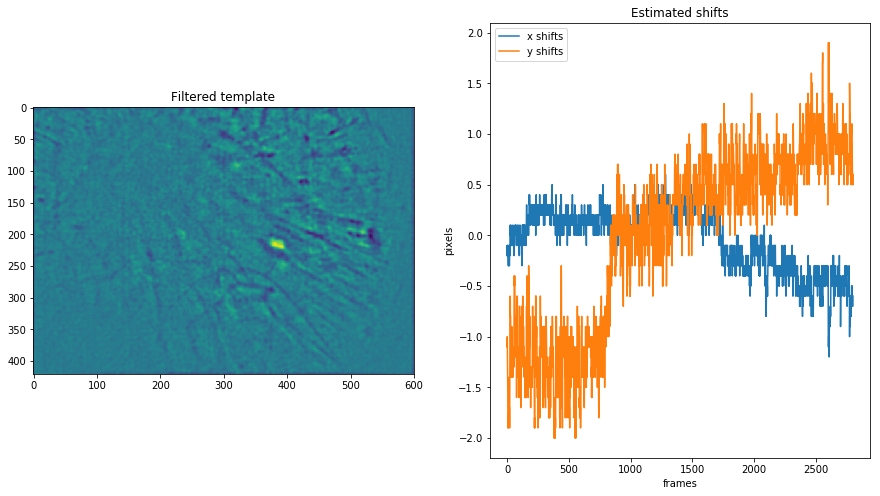

In [9]:
%matplotlib inline
if do_motion_correction_nonrigid or do_motion_correction_rigid:
    # do motion correction rigid
    mc = motion_correct_oneP_rigid(fnames,
                                   gSig_filt=gSig_filt,
                                   max_shifts=max_shifts,
                                   dview=dview,
                                   splits_rig=splits_rig,
                                   save_movie=not(do_motion_correction_nonrigid)
                                   )

    new_templ = mc.total_template_rig
    plt.figure(figsize=(15,8))
    plt.subplot(1,2,1)    
    plt.title('Filtered template')
    plt.imshow(new_templ)       #% plot template
    plt.subplot(1,2,2)
    plt.title('Estimated shifts')
    plt.plot(mc.shifts_rig)     #% plot rigid shifts
    plt.legend(['x shifts', 'y shifts'])
    plt.xlabel('frames')
    plt.ylabel('pixels')
    
    bord_px = np.ceil(np.max(np.abs(mc.shifts_rig))).astype(np.int)     #borders to eliminate from movie because of motion correction        

    # do motion correction nonrigid
    if do_motion_correction_nonrigid:
        mc = motion_correct_oneP_nonrigid(
            fnames,
            gSig_filt=gSig_filt,
            max_shifts=max_shifts,
            strides=strides,
            overlaps=overlaps,
            splits_els=splits_els,
            upsample_factor_grid=upsample_factor_grid,
            max_deviation_rigid=max_deviation_rigid,
            dview=dview,
            splits_rig=None,
            save_movie=True,  # whether to save movie in memory mapped format
            new_templ=new_templ  # template to initialize motion correction
        )

        bord_px = np.ceil(
            np.maximum(np.max(np.abs(mc.x_shifts_els)),
                       np.max(np.abs(mc.y_shifts_els)))).astype(np.int)

    # create memory mappable file in the right order on the hard drive (C order)        
        fname_new = cm.save_memmap([mc.fname_tot_els], base_name='memmap_',
                                   order = 'C', border_to_0=bord_px, dview=dview)
    else:
        fname_new = cm.save_memmap([mc.fname_tot_rig], base_name='memmap_',
                                   order = 'C', border_to_0=bord_px, dview=dview)
else:
    fname_new = cm.save_memmap(fnames, base_name='memmap_', order = 'C')

# load memory mappable file
Yr, dims, T = cm.load_memmap(fname_new)
Y = Yr.T.reshape((T,) + dims, order='F')

In [10]:
#load memory mappable file
Yr, dims, T = cm.load_memmap(fname_new)
Y = Yr.T.reshape((T,) + dims, order='F')

In [11]:
fname_new

'memmap__d1_420_d2_600_d3_1_order_C_frames_2800_.mmap'

Play the movie (optional). This will require loading the movie in memory which in general is not needed by the pipeline. Displaying the movie uses the OpenCV library. Press `q` to close the video panel. **BEWARE** the movie may appear in the background!

In [12]:
# m_orig = cm.movie(Y)
# downsample_ratio = 5
# offset_mov = -np.min(m_orig[:100])  # make the dataset mostly non-negative
# print(m_orig.shape)
# m_orig[::downsample_ratio,:,:].crop_gui(gain=3.5, offset=offset_mov, fr=30, magnification=1)#,plot_text=True)

### Inspect summary images and set parameters
Check the optimal values of min_corr and min_pnr by moving slider in the figure that pops up

/home/sebastian/Documents/CaImAn/caiman/summary_images.py:411: RuntimeWarning: invalid value encountered in true_divide
  pnr = np.divide(data_max, data_std)
/home/sebastian/Documents/CaImAn/caiman/summary_images.py:412: RuntimeWarning: invalid value encountered in less
  pnr[pnr < 0] = 0
/home/sebastian/Documents/CaImAn/caiman/summary_images.py:415: RuntimeWarning: invalid value encountered in true_divide
  tmp_data = data_filtered.copy() / data_std
/home/sebastian/Documents/CaImAn/caiman/summary_images.py:416: RuntimeWarning: invalid value encountered in less
  tmp_data[tmp_data < 3] = 0


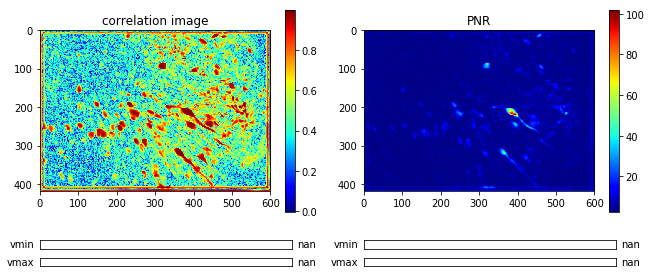

In [13]:
# compute some summary images (correlation and peak to noise)
cn_filter, pnr = cm.summary_images.correlation_pnr(Y, gSig=gSig_filt[0], swap_dim=False) # change swap dim if output looks weird, it is a problem with tiffile
# inspect the summary images and set the parameters
inspect_correlation_pnr(cn_filter, pnr)

In [14]:
# print parameters set above, modify them if necessary based on summary images
# print(min_corr) # min correlation of peak (from correlation image)
# print(min_pnr)  # min peak to noise ratio

In [15]:
target = '/home/sebastian/Desktop/mo_corr_substudy'




### Set CNMF parameters and run it

In [28]:
# parameters for source extraction and deconvolution
p = 1               # order of the autoregressive system
K = None            # upper bound on number of components per patch, in general None
gSig = 3            # gaussian width of a 2D gaussian kernel, which approximates a neuron
gSiz = 4*gSig+1     # average diameter of a neuron, in general 4*gSig+1
merge_thresh = .2   # merging threshold, max correlation allowed
rf = 48             # half-size of the patches in pixels. e.g., if rf=40, patches are 80x80
stride_cnmf = 24    # amount of overlap between the patches in pixels
#                     (keep it at least large as gSiz, i.e 4 times the neuron size gSig)
tsub = 2            # downsampling factor in time for initialization,
#                     increase if you have memory problems
ssub = 1            # downsampling factor in space for initialization,
#                     increase if you have memory problems
Ain = None          # if you want to initialize with some preselected components
#                     you can pass them here as boolean vectors
low_rank_background = None  # None leaves background of each patch intact,
#                             True performs global low-rank approximation 
gnb = -2            # number of background components (rank) if positive,
#                     else exact ring model with following settings
#                         gnb=-2: Return background as b and W
#                         gnb=-1: Return full rank background B
#                         gnb= 0: Don't return background
nb_patch = -1       # number of background components (rank) per patch,
#                     use 0 or -1 for exact background of ring model (cf. gnb)
min_corr = .6       # min peak value from correlation image
min_pnr = 7        # min peak to noise ration from PNR image
ssub_B = 2          # additional downsampling factor in space for background
ring_size_factor = 1.5  # radius of ring is gSiz*ring_size_factor

In [29]:
cnm = cnmf.CNMF(n_processes=n_processes,
                method_init='corr_pnr',             # use this for 1 photon
                k=K,
                gSig=(gSig, gSig),
                gSiz=(gSiz, gSiz),
                merge_thresh=merge_thresh,
                p=p,
                dview=dview,
                tsub=tsub,
                ssub=ssub,
                Ain=Ain,
                rf=rf,
                stride=stride_cnmf,
                only_init_patch=True,               # just leave it as is
                gnb=gnb,
                nb_patch=nb_patch,
                method_deconvolution='oasis',       # could use 'cvxpy' alternatively
                low_rank_background=low_rank_background,
                update_background_components=True,  # sometimes setting to False improve the results
                min_corr=min_corr,
                min_pnr=min_pnr,
                normalize_init=False,               # just leave as is
                center_psf=True,                    # leave as is for 1 photon
                ssub_B=ssub_B,
                ring_size_factor=ring_size_factor,
                del_duplicates=True,                # whether to remove duplicates from initialization
                border_pix=bord_px)                 # number of pixels to not consider in the borders
cnm.fit(Y)

(2800, 420, 600)
using 16 processes
using 4000 pixels per process
using 5000 block_size
(96, 96)
477.98375844955444
Transforming patches into full matrix
Skipped %d Empty Patch 0
Generating background


/home/sebastian/Documents/CaImAn/caiman/source_extraction/cnmf/map_reduce.py:425: RuntimeWarning: divide by zero encountered in true_divide
  (1. / mask, (np.arange(d), np.arange(d))), dtype=np.float32)


Leaving background components intact
Generating background DONE
merging


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


[19 21]
[24 28]
No neurons merged!


In [23]:
bord_px

6

In [30]:
from caiman.utils.utils import save_object

cnm.dview=None

save_object(cnm, '/home/sebastian/Desktop/cnm.pkl')

In [31]:
%matplotlib inline

import matplotlib.pyplot as plt

spikes = cnm.S.copy()

# for i in range(spikes.shape[0]):
#     spikes[i,:]=spikes[i,:]/spikes[i,:].max()

# spikes[spikes.sum(1)>spikes.sum(1).mean(),:]=0
 
# plt.plot(spikes.sum(1)>spikes.sum(1).mean())
    
plt.imshow(spikes,aspect='auto')
#plt.yticks(range(21),range(1,22))

In [32]:
# y = np.zeros((1000000,))

# multi_step =[
#  [0.005, 10000],
#  [0.02, 430000],
#  [0.002, 730000],
#  [0.001, 1030000]]

# n = 0
# for step in multi_step:
#     print(step,n,step[1])
#     y[n:step[1]]=step[0]
#     n=step[1]
   

# d1=0.0001
# d2=0.01
# x1 = np.arange(y.shape[0])
# y1 = (x1*d1)*(0.9**(x1*d1))*d2 

# plt.plot(x1,y)
# plt.hold(True)
# plt.plot(x1,y1)

# try:
#     a = np.linalg.inv(np.zeros((3,3)))
# except:
#     a = np.linalg.lstsq(np.zeros((3,3)),[1,1,1])
#     print('tried...',a)


# m1 = cm.load('/home/sebastian/Desktop/32363_20170710_132114_trial.tif')
# print(m1.shape)


# plt.imshow(m1[1550,:,:]) 


plot contours of identified components against correlation image

/home/sebastian/Documents/CaImAn/caiman/summary_images.py:411: RuntimeWarning: invalid value encountered in true_divide
  pnr = np.divide(data_max, data_std)
/home/sebastian/Documents/CaImAn/caiman/summary_images.py:412: RuntimeWarning: invalid value encountered in less
  pnr[pnr < 0] = 0
/home/sebastian/Documents/CaImAn/caiman/summary_images.py:415: RuntimeWarning: invalid value encountered in true_divide
  tmp_data = data_filtered.copy() / data_std
/home/sebastian/Documents/CaImAn/caiman/summary_images.py:416: RuntimeWarning: invalid value encountered in less
  tmp_data[tmp_data < 3] = 0
/home/sebastian/Documents/CaImAn/caiman/utils/visualization.py:953: UserWarning: The way to call utilities.plot_contours has changed. Look at the definition for more details.
  "Look at the definition for more details.")


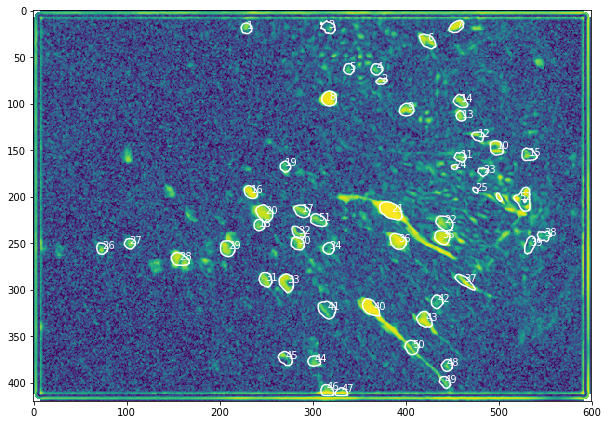

In [33]:
%matplotlib inline

from caiman.summary_images import correlation_pnr

cn_filter, pnr = correlation_pnr(Y, gSig=gSig, swap_dim=False)

plt.figure(figsize=(10,10))
crd = cm.utils.visualization.plot_contours(cnm.A, cn_filter, thr=.8, vmax=0.99)

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


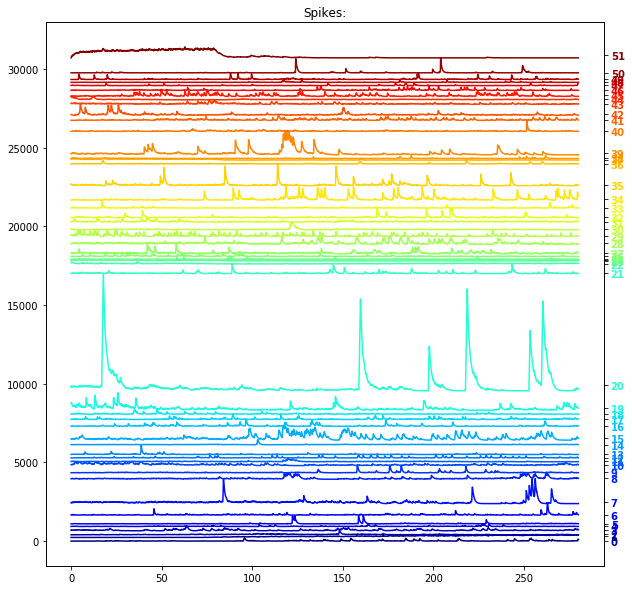

In [34]:
from caiman.base.traces import trace

plt.figure(figsize=(10,10))

trc = trace(cnm.S.T,fr = 10)
plt.title('Spikes:')
trc.plot()


## Component Evaluation

The processing in patches creates several spurious components. These are filtered out by evaluating each component using three different criteria:

- the shape of each component must be correlated with the data at the corresponding location within the FOV
- a minimum peak SNR is required over the length of a transient
- each shape passes a CNN based classifier

<img src="../../docs/img/evaluationcomponent.png"/>

In [ ]:
# parameters for component evaluation
min_SNR = 5            # adaptive way to set threshold on the transient size
r_values_min = 0.6    # threshold on space consistency (if you lower more components
#                        will be accepted, potentially with worst quality)

In [ ]:
#%% COMPONENT EVALUATION
# the components are evaluated in three ways:
#   a) the shape of each component must be correlated with the data
#   b) a minimum peak SNR is required over the length of a transient
#   c) each shape passes a CNN based classifier

idx_components, idx_components_bad, comp_SNR, r_values, pred_CNN = estimate_components_quality_auto(
                            Y, cnm.A, cnm.C, cnm.b, cnm.f, cnm.YrA, frate, 
                            decay_time, gSig, dims, dview=None, 
                            min_SNR=min_SNR, r_values_min=r_values_min, use_cnn=False)

print(' ***** ')
print((len(cnm.C)))
print((len(idx_components)))
print(r_values[idx_components_bad])

Plot contours of selected and rejected components

In [ ]:
#%% PLOT COMPONENTS

plt.figure(figsize=(15,8));
plt.subplot(121);
crd = cm.utils.visualization.plot_contours(cnm.A.tocsc()[:,idx_components], cn_filter, thr=.8, vmax=0.95)
plt.title('Contour plots of accepted components')
plt.subplot(122); 
crd = cm.utils.visualization.plot_contours(cnm.A.tocsc()[:,idx_components_bad], cn_filter, thr=.8, vmax=0.95)
plt.title('Contour plots of rejected components');

View traces of accepted and rejected components. Note that if you get data rate error you can start Jupyter notebooks using:
'jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10'

In [ ]:
# accepted components
nb_view_patches(Yr, cnm.A.tocsc()[:, idx_components], cnm.C[idx_components], 
                cnm.b, cnm.f, dims[0], dims[1], YrA=cnm.YrA[idx_components], image_neurons=cn_filter,
                denoised_color='red', thr=0.8, cmap='gray');

In [ ]:
# rejected components
nb_view_patches(Yr, cnm.A.tocsc()[:, idx_components_bad], cnm.C[idx_components_bad], 
                cnm.b, cnm.f, dims[0], dims[1], YrA=cnm.YrA[idx_components_bad], image_neurons=cn_filter,
                denoised_color='red', thr=0.8, cmap='gray');

### Stop cluster

In [ ]:
cm.stop_server(dview=dview)

### Some instructive movies

In [ ]:
B = cnm.b.dot(cnm.f)
if 'sparse' in str(type(B)):
    B = B.toarray()

In [ ]:
#%% denoised movie
cm.movie(np.reshape(cnm.A.tocsc()[:,idx_components].dot(cnm.C[idx_components])+B,dims+(-1,), order = 'F').transpose(2,0,1)).play(magnification=1, gain = 1.)

In [ ]:
#%% only neurons
cm.movie(np.reshape(cnm.A.tocsc()[:,idx_components].dot(cnm.C[idx_components]),dims+(-1,), order = 'F').transpose(2,0,1)).play(magnification=1, gain = 10.)

In [ ]:
#%% only the background
cm.movie(np.reshape(B,dims+(-1,), order = 'F').transpose(2,0,1)).play(magnification=1, gain = 1.)

In [ ]:
#%% residuals
cm.movie(np.array(Y)-np.reshape(cnm.A.tocsc()[:,:].dot(cnm.C[:])+B,dims+(-1,), order = 'F').transpose(2,0,1)).play(magnification=1, gain = 1., fr = 10)


In [ ]:
#%% eventually, you can rerun the algorithm on the residuals
plt.imshow(cm.movie(np.array(Y)-np.reshape(cnm.A.tocsc()[:,:].dot(cnm.C[:])+B,dims+(-1,), order = 'F').transpose(2,0,1)).local_correlations(swap_dim=False))